# 미션 7 개요

SSD 모델을 활용하여 개와 고양이의 얼굴(Face) 영역을 감지하는 Object Detection 작업을 수행

데이터
- The Oxford-IIIT Pet Dataset
    - annotations(xml) : 각 이미지 파일에 대한 annotation
    - images : 이미지 파일(37종의 개와 고양이)

모델 성능 평가
- 평가 지표(mAP, IOU 등)를 활용해 모델 성능을 분석하고 비교
- 제공된 데이터셋의 테스트 파일을 사용하여 모델을 테스트

# 환경설정

In [28]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import pandas as pd

from pathlib import Path
import kagglehub

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torchvision.models as models
from torchvision import models
from torchinfo import summary

from PIL import Image, ImageEnhance, ImageFilter
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms.v2 as v2
import math
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import copy

from torchvision.transforms.functional import to_pil_image

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from datetime import datetime
from collections import Counter
from torch.utils.data import WeightedRandomSampler
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
import torchvision
from torchvision.models.detection.ssd import SSD300_VGG16_Weights

In [3]:
print("PyTorch:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

os.makedirs("pth", exist_ok=True)

PyTorch: 2.7.1
MPS available: True
mps


## 함수화

In [5]:
# 바운딩 박스를 그림으로 표시하는 함수 정의
def draw_bbox(ax, box, text, color):
    """
    - ax: matplotlib Axes 객체
    - box: 바운딩 박스 좌표 (x_min, y_min, x_max, y_max)
    - text: 바운딩 박스 위에 표시할 텍스트
    - color: 바운딩 박스와 텍스트의 색상
    """
    ax.add_patch(
        plt.Rectangle(
            xy=(box[0], box[1]),
            width=box[2] - box[0],
            height=box[3] - box[1],
            fill=False,
            edgecolor=color,
            linewidth=2,
        )
    )
    ax.annotate(
        text=text,
        xy=(box[0] - 5, box[1] - 5),
        color=color,
        weight="bold",
        fontsize=13,
    )

## 데이터 불러오기

In [6]:
# KaggleHub 캐시를 현재 노트북 폴더 안에 .kagglehub_cache 로 고정
cache_dir = Path.cwd() / ".kagglehub_cache"
cache_dir.mkdir(parents=True, exist_ok=True)
os.environ["KAGGLEHUB_CACHE"] = str(cache_dir)

print(cache_dir)

# Download latest version
path = kagglehub.dataset_download("devdgohil/the-oxfordiiit-pet-dataset")

print("Path to dataset files:", path)

/Users/leeyoungho/develop/ai_study/mission/mission7/.kagglehub_cache
Path to dataset files: /Users/leeyoungho/develop/ai_study/mission/mission7/.kagglehub_cache/datasets/devdgohil/the-oxfordiiit-pet-dataset/versions/2


In [7]:
# 파일 경로 설정
trainval_file_path = os.path.join(path, "annotations", "annotations", "trainval.txt")
test_file_path = os.path.join(path, "annotations", "annotations", "test.txt")

# 이미지, Annotation 경로 설정
image_dir = os.path.join(path, "images", "images")
xml_dir = os.path.join(path, "annotations", "annotations", "xmls")

# Train/Validation 파일 읽기
df_trainval = pd.read_csv(trainval_file_path, sep="\s+", header=None)
df_trainval.columns = ["Image", "ClassID", "Species", "BreedID"]

# Test 파일 읽기
df_test = pd.read_csv(test_file_path, sep="\s+", header=None)
df_test.columns = ["Image", "ClassID", "Species", "BreedID"]

# 데이터 크기 확인
print(f"Train/Validation 데이터 수: {len(df_trainval)}")
print(f"Test 데이터 수: {len(df_test)}")

# Annotation 개수 확인
xml_files = [file for file in os.listdir(xml_dir) if file.endswith(".xml")]
print(f"XML 파일 개수: {len(xml_files)}")

Train/Validation 데이터 수: 3680
Test 데이터 수: 3669
XML 파일 개수: 3686


<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mv/xvtnn0v91cx8bl846n_qn4100000gn/T/ipykernel_92312/359302660.py:10: SyntaxWarning: invalid escape sequence '\s'
  df_trainval = pd.read_csv(trainval_file_path, sep="\s+", header=None)
/var/folders/mv/xvtnn0v91cx8bl846n_qn4100000gn/T/ipykernel_92312/359302660.py:14: SyntaxWarning: invalid escape sequence '\s'
  df_test = pd.read_csv(test_file_path, sep="\s+", header=None)


In [8]:
print(df_trainval.shape)
df_trainval.head()

(3680, 4)


,Image,ClassID,Species,BreedID
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [9]:
print(df_test.shape)
df_test.head()

(3669, 4)


,Image,ClassID,Species,BreedID
0,Abyssinian_201,1,1,1
1,Abyssinian_202,1,1,1
2,Abyssinian_204,1,1,1
3,Abyssinian_205,1,1,1
4,Abyssinian_206,1,1,1


In [10]:
df_trainval['Species'].value_counts()

Species
2    2492
1    1188
Name: count, dtype: int64

In [11]:
df_test['Species'].value_counts()

Species
2    2486
1    1183
Name: count, dtype: int64

In [12]:
# Train과 Validation에 사용될 이미지 파일 이름 리스트 생성
trainval_list = df_trainval['Image'].tolist()

# Test에 사용될 이미지 파일 이름 리스트 생성
test_list = df_test['Image'].tolist()

In [13]:
# XML 파일 이름 가져오기 (확장자 제거)
xml_list = [os.path.splitext(file)[0] for file in os.listdir(xml_dir) if file.endswith(".xml")]

# Train 이미지에 대해 XML 파일이 없는 경우 확인
missing_xml = [image for image in trainval_list if image not in xml_list]

# Train 이미지에 대해 XML 파일이 있는 경우 확인
trainval_list = [image for image in trainval_list if image in xml_list]

# 결과 출력
print(f"XML 파일이 없는 Train 이미지 수: {len(missing_xml)}")
print(missing_xml)

XML 파일이 없는 Train 이미지 수: 9
['Abyssinian_104', 'Bengal_111', 'samoyed_10', 'Bengal_175', 'Egyptian_Mau_14', 'Egyptian_Mau_156', 'Egyptian_Mau_186', 'Ragdoll_199', 'saint_bernard_15']


In [14]:
import xml.etree.ElementTree as ET

# 예제 XML 파일 경로
example_xml_file = os.path.join(xml_dir, xml_files[0])

# XML 파일 읽기 및 파싱
tree = ET.parse(example_xml_file)
root = tree.getroot()

# 재귀적으로 모든 태그와 데이터 출력 함수
def print_all_elements(element, indent=""):
    print(f"{indent}{element.tag}: {element.text}")
    for child in element:
        print_all_elements(child, indent + "  ")

# XML 구조 탐색
print_all_elements(root)

annotation: None
  folder: OXIIIT
  filename: British_Shorthair_10.jpg
  source: None
    database: OXFORD-IIIT Pet Dataset
    annotation: OXIIIT
    image: flickr
  size: None
    width: 233
    height: 350
    depth: 3
  segmented: 0
  object: None
    name: cat
    pose: Frontal
    truncated: 0
    occluded: 0
    bndbox: None
      xmin: 83
      ymin: 29
      xmax: 197
      ymax: 142
    difficult: 0


In [15]:
# 모든 XML 파일 처리
annotations = []

for xml_file in xml_files:
    xml_path = os.path.join(xml_dir, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    image_name = root.find("filename").text  # 이미지 파일 이름

    for obj in root.findall("object"):
        class_name = obj.find("name").text
        bndbox = obj.find("bndbox")
        x_min = int(bndbox.find("xmin").text)
        y_min = int(bndbox.find("ymin").text)
        x_max = int(bndbox.find("xmax").text)
        y_max = int(bndbox.find("ymax").text)

        annotations.append({
            "image": image_name,
            "class": class_name,
            "bbox": [x_min, y_min, x_max, y_max]
        })

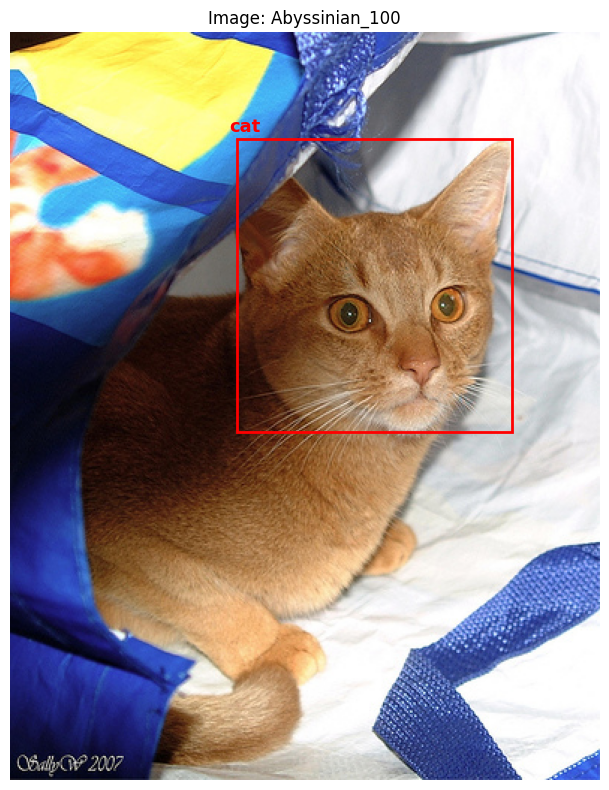

In [16]:
# Train 데이터에서 예제 이미지 불러오기
train_example_image_name = df_trainval["Image"].iloc[0]
train_image_path = os.path.join(image_dir, f"{train_example_image_name}.jpg")

# 이미지 읽기
image = cv2.imread(train_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 해당 이미지의 어노테이션 가져오기
annotations = [anno for anno in annotations if anno["image"] == f"{train_example_image_name}.jpg"]

# Bounding Box 그리기
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(image)

# 각 annotation에 대해 바운딩 박스 그리기
for anno in annotations:
    bbox = anno["bbox"]
    class_name = anno["class"]

    # 클래스에 따른 색상 결정
    color = "red" if class_name == "cat" else "blue"

    # 바운딩 박스 그리기
    draw_bbox(ax, bbox, class_name, color)

ax.set_title(f"Image: {train_example_image_name}")
ax.axis("off")
plt.tight_layout()
plt.show()

# Dataset 준비

In [17]:
# 이미지 전처리: PIL 이미지를 텐서로 변환하고, 데이터 타입을 float으로 변환
transform = v2.Compose(
    [
        v2.ToImage(), #PIL 이미지를 텐서로 변환, 자동으로 정규화: 0-255 범위를 0-1 범위로 자동 스케일링
        v2.ToDtype(dtype=torch.float32, scale=True),
    ]
)

In [19]:
class VOCDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, classes, image_list, transforms=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.classes = classes
        self.transforms = transforms
        self.image_files = image_list

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # 이미지 및 XML 파일 경로 설정
        image_file = self.image_files[idx] + ".jpg"
        annotation_file = self.image_files[idx] + ".xml"
        image_path = os.path.join(self.image_dir, image_file)
        annotation_path = os.path.join(self.annotation_dir, annotation_file)

        # 이미지 로드
        image = Image.open(image_path).convert("RGB")

        # 어노테이션 로드
        boxes = []
        labels = []
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        for obj in root.findall("object"):
            class_name = obj.find("name").text
            if class_name not in self.classes:
                continue

            bndbox = obj.find("bndbox")
            x_min = int(bndbox.find("xmin").text)
            y_min = int(bndbox.find("ymin").text)
            x_max = int(bndbox.find("xmax").text)
            y_max = int(bndbox.find("ymax").text)
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(self.classes.index(class_name))

        # Tensor로 변환
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        # Transform 적용
        if self.transforms:
            image, boxes, labels = self.transforms(image, boxes, labels)

        target = {"boxes": boxes, "labels": labels}

        return image, target

In [22]:
class TestDataset(Dataset):
    def __init__(self, image_dir, image_list, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms
        self.image_files = image_list  # 테스트 이미지 리스트 (확장자 없음)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # 이미지 파일 경로
        image_file = self.image_files[idx] + ".jpg"
        image_path = os.path.join(self.image_dir, image_file)

        # 이미지 로드
        image = Image.open(image_path).convert("RGB")

        # Transform 적용
        if self.transforms:
            image = self.transforms(image)

        return image, self.image_files[idx]  # 이미지와 파일 이름 반환

In [24]:
# Train/Validation 분리 (trainval_list에서 70% Train, 30% Validation으로 나눔)
train_list, valid_list = train_test_split(trainval_list, test_size=0.3, random_state=42)

# 결과 확인
print(f"Train 이미지 수: {len(train_list)}")
print(f"Validation 이미지 수: {len(valid_list)}")
print(f"Test 이미지 수: {len(test_list)}")

Train 이미지 수: 2569
Validation 이미지 수: 1102
Test 이미지 수: 3669


In [25]:
# 클래스 정의
classes = ["background", "dog", "cat"]

# Train Dataset
train_dataset = VOCDataset(
    image_dir=image_dir,
    annotation_dir=xml_dir,
    classes=classes,
    image_list=train_list,  # Train 리스트 사용
    transforms=transform
)

# Validation Dataset
valid_dataset = VOCDataset(
    image_dir=image_dir,
    annotation_dir=xml_dir,
    classes=classes,
    image_list=valid_list,  # Validation 리스트 사용
    transforms=transform
)

# Test Dataset 생성
test_dataset = TestDataset(
    image_dir=image_dir,  # 테스트 이미지 디렉토리
    image_list=test_list,       # 테스트 이미지 리스트 (확장자 없는 이름)
    transforms=transform  # 필요하면 Transform 적용
)


# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# 데이터 크기 출력
print(f"Train 데이터셋 크기: {len(train_dataset)}")
print(f"Validation 데이터셋 크기: {len(valid_dataset)}")
print(f"Test 데이터셋 크기: {len(test_dataset)}")


Train 데이터셋 크기: 2569
Validation 데이터셋 크기: 1102
Test 데이터셋 크기: 3669


# SSD 모델 준비

In [29]:
# SSD 모델 불러오기
model = torchvision.models.detection.ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT).to(device)

# 클래스 개수에 맞게 출력 레이어 수정
num_classes = len(classes)  # background 포함
model.head.classification_head.num_classes = num_classes

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /Users/leeyoungho/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth


100%|██████████| 136M/136M [00:02<00:00, 60.3MB/s] 


# 모델 학습 및 평가

In [34]:
from torch import gt


def compute_iou_numpy(boxes1, boxes2):
    """
    numpy를 사용하여 두 박스 집합 간의 IoU(Intersection over Union)를 계산합니다.
    :param boxes1: (N, 4) 배열, 각 박스는 [x_min, y_min, x_max, y_max] 형태
    :param boxes2: (M, 4) 배열, 각 박스는 [x_min, y_min, x_max, y_max] 형태
    :return: (N, M) IoU 배열
    """
    # 각 박스의 면적 계산
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    # 교집합 좌표 계산
    inter_x1 = np.maximum(boxes1[:, None, 0], boxes2[None, :, 0])
    inter_y1 = np.maximum(boxes1[:, None, 1], boxes2[None, :, 1])
    inter_x2 = np.minimum(boxes1[:, None, 2], boxes2[None, :, 2])
    inter_y2 = np.minimum(boxes1[:, None, 3], boxes2[None, :, 3])

    inter_w = np.maximum(inter_x2 - inter_x1, 0)
    inter_h = np.maximum(inter_y2 - inter_y1, 0)
    inter_area = inter_w * inter_h
    union_area = area1[:, None] + area2 - inter_area
    return inter_area / (union_area + 1e-6)
    
    
    
def voc_ap(recalls, precisions):
    """
    VOC 방식의 AP(Average Precision) 계산 함수.
    :param recalls: 재현율 배열 (오름차순)
    :param precisions: 정밀도 배열 (recalls에 대응하는 값)
    :return: AP 값 (0과 1 사이의 값)
    """
    # 양쪽 끝을 0과 1로 패딩
    mrec = np.concatenate(([0.], recalls, [1.]))
    mpre = np.concatenate(([0.], precisions, [0.]))

    # 정밀도 보정: 뒤에서부터 최대값으로 보정
    for i in range(len(mpre) - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # recall 변화가 있는 지점에서 면적을 합산
    idx = np.where(mrec[1:] != mrec[:-1])[0]

    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])
    return ap


def evaluate_detections(predictions, ground_truths, iou_threshold=0.5, num_classes=3):
    """
    예측 결과와 Ground Truth를 바탕으로 클래스별 AP와 전체 mAP를 계산합니다.
    :param predictions: 각 예측 인스턴스를 담은 리스트 (dict 형식)
           예: { "image_id": int, "bbox": [x, y, w, h], "score": float, "label": int }
    :param ground_truths: 전체 Ground Truth를 담은 리스트 (dict 형식)
           예: { "image_id": int, "boxes": numpy array of shape (N,4), "labels": numpy array of shape (N,) }
    :param iou_threshold: IoU 임계값 (기본 0.5)
    :param num_classes: 전체 클래스 수 (배경 포함)
    :return: 전체 mAP (mean Average Precision)
    """

    aps = []
    for cls in range(1, num_classes):
        cls_preds = [p for p in predictions if p["label"] == cls]
        cls_preds = sorted(cls_preds, key=lambda p: p["score"], reverse=True)
        
        gt_by_image = {}
        for gt in ground_truths:
            inds = np.where(gt["labels"] == cls)[0]
            boxes = gt["boxes"][inds] if len(inds) > 0 else np.array([]).reshape(0, 4)
            gt_by_image[gt["image_id"]] = {"boxes": boxes, "detected": np.zeros(len(boxes), dtype=bool)}

        num_gt = sum([len(v["boxes"]) for v in gt_by_image.values()])
        if num_gt == 0:
            continue

        tp = np.zeros(len(cls_preds))
        fp = np.zeros(len(cls_preds))
        for i, pred in enumerate(cls_preds):
            image_id = pred["image_id"]
            pred_box = np.array(pred["bbox"]) # [x, y, w, h]
            # [x, y, w, h] -> [x_min, y_min, x_max, y_max] 변환
            pred_box_xyxy = np.array([pred_box[0], pred_box[1], pred_box[0] + pred_box[2], pred_box[1] + pred_box[3]])
            if image_id in gt_by_image:
                gt_boxes = gt_by_image[image_id]["boxes"]
                if gt_boxes.shape[0] == 0:
                    fp[i] = 1
                else:
                    ious = compute_iou_numpy(np.expand_dims(pred_box_xyxy, axis=0), gt_boxes)
                    max_iou = np.max(ious) if ious.size > 0 else 0
                    max_ind = np.argmax(ious) if ious.size > 0 else -1
                    if max_iou >= iou_threshold:
                        # 아직 매칭되지 않은 Ground Truth이면 true positive 처리
                        if not gt_by_image[image_id]["detected"][max_ind]:
                            tp[i] = 1
                            gt_by_image[image_id]["detected"][max_ind] = True
                        else:
                            fp[i] = 1
                    else:
                        fp[i] = 1
            else:
                fp[i] = 1

        cum_tp = np.cumsum(tp)
        cum_fp = np.cumsum(fp)
        recalls = cum_tp / (num_gt + 1e-6)
        precisions = cum_tp / (cum_tp + cum_fp + 1e-6)
        ap = voc_ap(recalls, precisions)
        print(f"클래스 {cls} AP: {ap:.3f}")
        aps.append(ap)

    mAP = np.mean(aps) if aps else 0.0
    print(f"전체 mAP: {mAP:.3f}")
    return mAP

In [40]:
# Optimizer와 Loss 정의
opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.1)

In [45]:
from tqdm import tqdm

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    #tqdm 진행바를 사용하여 학습 진행 상황 표시
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
    for images, targets in train_bar:
        #이미지와 타겟을 디바이스로 이동
        # images.to(devie) 로는 처리가 안됨.

        # 데이터가 텐서형태로 있지 않기 때문에
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        # 모델에 입력하여 손실(loss) 계산
        # model에서 output이 loss dict형태로 내보냄
        loss_dict = model(images, targets)
        # loss_dict에서 값(val)만 추출해서 모두 sum
        losses = sum(loss for loss in loss_dict.values())

        opt.zero_grad()     # 기울기 초기화
        losses.backward()   # 역전파 수행
        opt.step()          # 파라미터 업데이트

        total_loss += losses.item()
        train_bar.set_postfix(loss=f"{losses.item():.3f}")
        
     # 평균 손실 계산
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch: {epoch+1:2d}, Avg Train Loss: {avg_train_loss:.3f}")

    # Validation Phase
    if 'val_loader' in locals():
        model.eval()
        all_predictions = []
        all_ground_truths = []

        with torch.no_grad():
            for images, targets in tqdm(val_loader, desc="Validation"):
                images = [img.to(device) for img in images]
                predictions = model(images)

                # 저장: 추론 결과와 Ground Truth
                all_predictions.extend(predictions)
                all_ground_truths.extend(targets)

        # 성능 평가 (예: mAP 계산)
        if 'evaluate_detections' in globals():
            mAP = evaluate_detections(all_predictions, all_ground_truths, classes)
            print(f"Epoch {epoch + 1}/{num_epochs}, Validation mAP: {mAP:.4f}\n")

    lr_scheduler.step() # 에폭이 끝난 후 학습률 업데이트
    

    # 사용하지 않는 GPU 메모리 해제 (메모리 최적화)
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()
    else:
        torch.cuda.empty_cache()


Epoch 1/5 - Training: 100%|██████████| 322/322 [03:48<00:00,  1.41it/s, loss=0.386]


Epoch:  1, Avg Train Loss: 0.469


Validation: 100%|██████████| 138/138 [02:01<00:00,  1.14it/s]


KeyError: 'label'

In [35]:
# Ground Truth와 예측 결과 준비

# test_dataset.data는 (image, target) 튜플의 리스트이며,
# target에는 "image_id", "boxes", "labels"가 tensor 형태로 저장되어 있습니다.
ground_truths = []
for _, target in test_dataset.data:
    gt = {
        "image_id": int(target["image_id"].item()),
        "boxes": target["boxes"].numpy(),  # [x_min, y_min, x_max, y_max]
        "labels": target["labels"].numpy()
    }
    ground_truths.append(gt)

# 예측 결과 생성 (각 예측은 dict 형식으로 저장)
# 예: { "image_id": int, "bbox": [x, y, w, h], "score": float, "label": int }
predictions = []
with torch.no_grad():
    model.eval()
    for images, targets in test_dataloader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        for i in range(len(targets)):
            image_id = int(targets[i]["image_id"].item())
            # 예측된 박스는 [x_min, y_min, x_max, y_max] 형태입니다.
            boxes = outputs[i]["boxes"].data.cpu().numpy()
            scores = outputs[i]["scores"].data.cpu().numpy()
            labels = outputs[i]["labels"].data.cpu().numpy()
            for j in range(len(boxes)):
                box = boxes[j]
                # [x_min, y_min, x_max, y_max] -> [x, y, w, h]로 변환 (w = x_max - x_min, h = y_max - y_min)
                bbox = [box[0], box[1], box[2] - box[0], box[3] - box[1]]
                predictions.append({
                    "image_id": image_id,
                    "bbox": bbox,
                    "score": float(scores[j]),
                    "label": int(labels[j])
                })

# 평가 실행: 강아지, 고양이(배경은 제외한 1, 2번 클래스)의 AP와 전체 mAP 계산
evaluate_detections(predictions, ground_truths, iou_threshold=0.5, num_classes=3)

AttributeError: 'TestDataset' object has no attribute 'data'